In [1]:
import sys
sys.path.append("../")
sys.path.append("../../../assets/diffusion")

# Get rid of annoying tf warning
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import bayesflow as beef
import pandas as pd

from experiments import RandomWalkDiffusionExperiment
from models import RandomWalkDiffusion
from configuration import default_num_steps

/Users/lukas/opt/miniconda3/envs/bfPower/lib/python3.10/site-packages/bayesflow/trainers.py:26: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [4]:
# If set to False, existing results will be loaded
# Set to True if you want to re-run the experiments
TRAIN_NETWORKS = True

NUM_SAMPLES = 4000

PARAM_LABELS = ['Drift rate', 'Threshold', 'Non-decision time']
PARAM_NAMES  = [r'$v$', r'$a$', r'$\tau$']
FONT_SIZE_1 = 20
FONT_SIZE_2 = 18
FONT_SIZE_1 = 16

## Neural Experiment

In [3]:
model = RandomWalkDiffusion(**default_num_steps)
neural_experiment = RandomWalkDiffusionExperiment(model)

INFO:root:Performing 2 pilot runs with the random_walk_diffusion_model model...
INFO:root:Shape of parameter batch after 2 pilot simulations: (batch_size = 2, 1320, 3)
INFO:root:Shape of simulation batch after 2 pilot simulations: (batch_size = 2, 1320)
INFO:root:Shape of hyper_prior_draws batch after 2 pilot simulations: (batch_size = 2, 3)
INFO:root:Shape of local_prior_draws batch after 2 pilot simulations: (batch_size = 2, 1320, 3)
INFO:root:No shared_prior_draws provided.
INFO:root:No optional simulation batchable context provided.
INFO:root:No optional simulation non-batchable context provided.
INFO:root:No optional prior batchable context provided.
INFO:root:No optional prior non-batchable context provided.
INFO:root:Initialized empty loss history.
INFO:root:Initialized networks from scratch.
INFO:root:Performing a consistency check with provided components...
INFO:root:Done.


### Training

In [7]:
if TRAIN_NETWORKS:
    history = neural_experiment.run(
        epochs=100, 
        iterations_per_epoch=1000, 
        batch_size=8
    )
else:
    history = neural_experiment.trainer.loss_history.get_plottable()

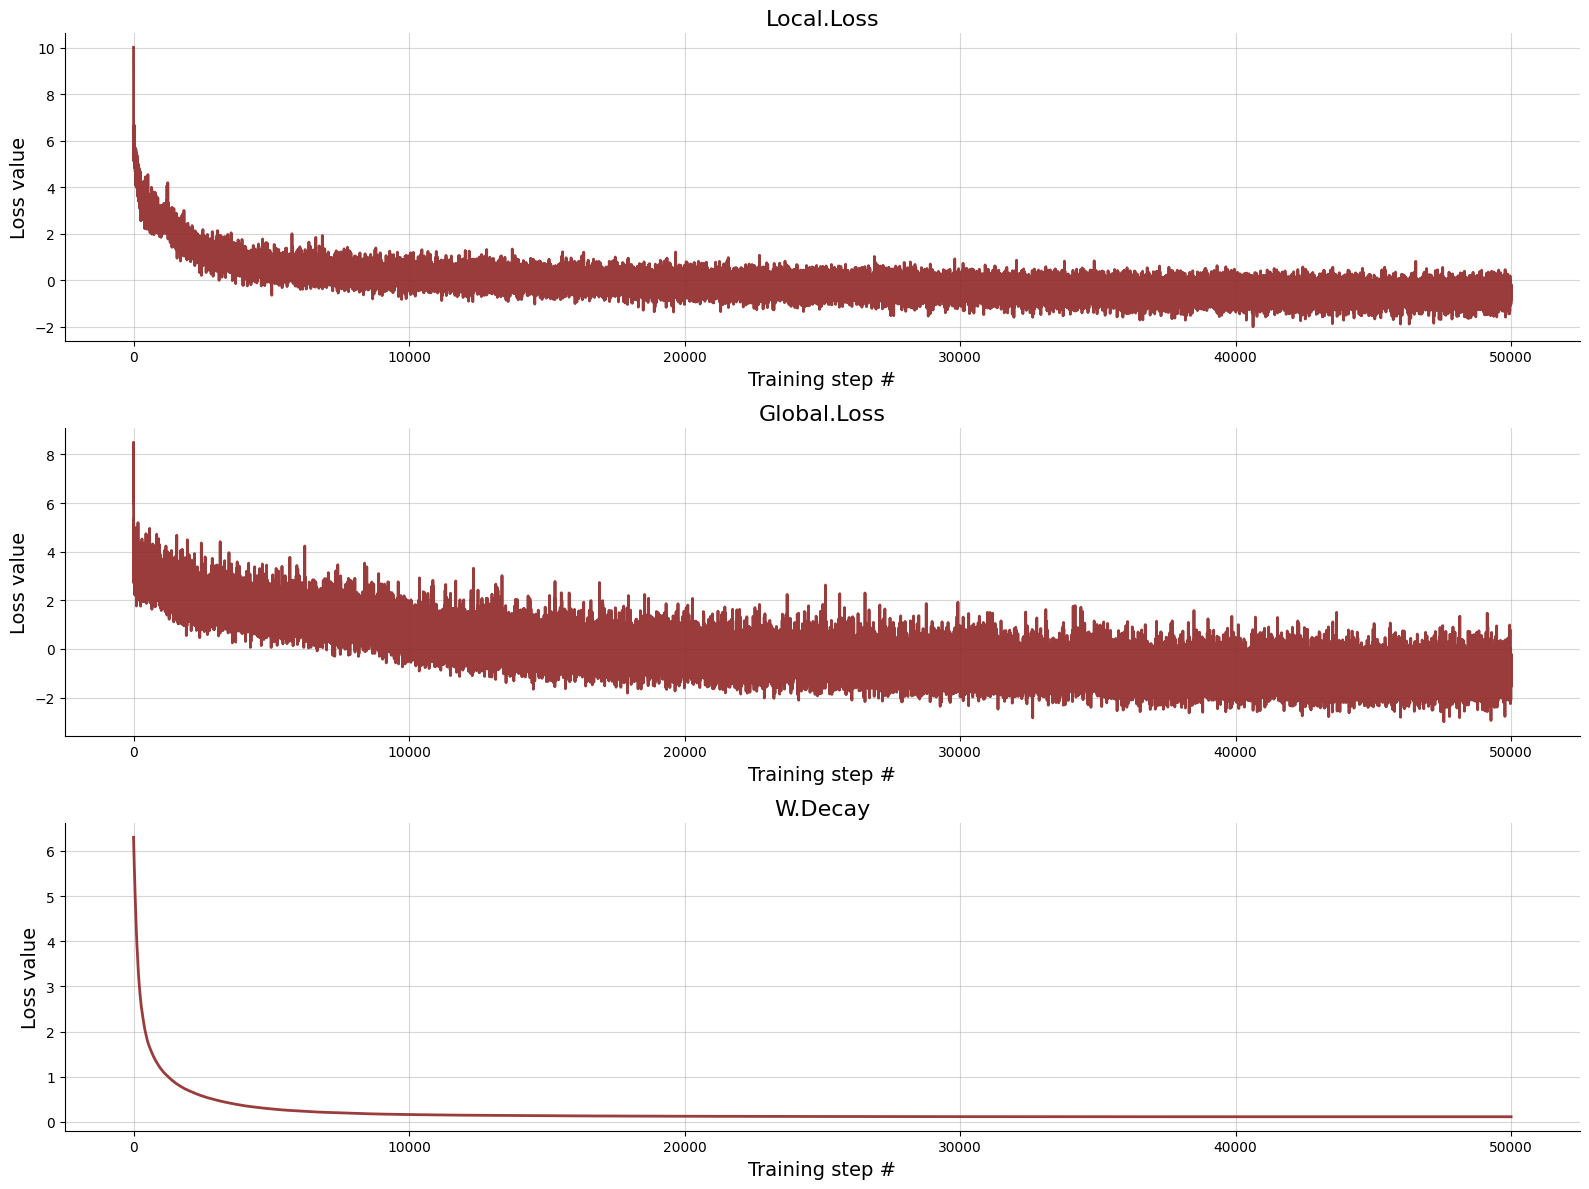

In [8]:
f = beef.diagnostics.plot_losses(history)

## Evaluation

### Prior predictive checks

In [22]:
sim_data = model.generate(1)
true_params = sim_data['local_prior_draws'][0]

In [23]:
post_samples = neural_experiment.amortizer.sample(model.configure(sim_data), NUM_SAMPLES)

In [26]:
post_samples['local_samples'].shape
theta_t = post_samples['local_samples'] * model.local_prior_stds + model.local_prior_means
theta_t_means = theta_t.mean(axis=1)
theta_t_stds = theta_t.std(axis=1)

<bound method Figure.tight_layout of <Figure size 2000x1000 with 3 Axes>>

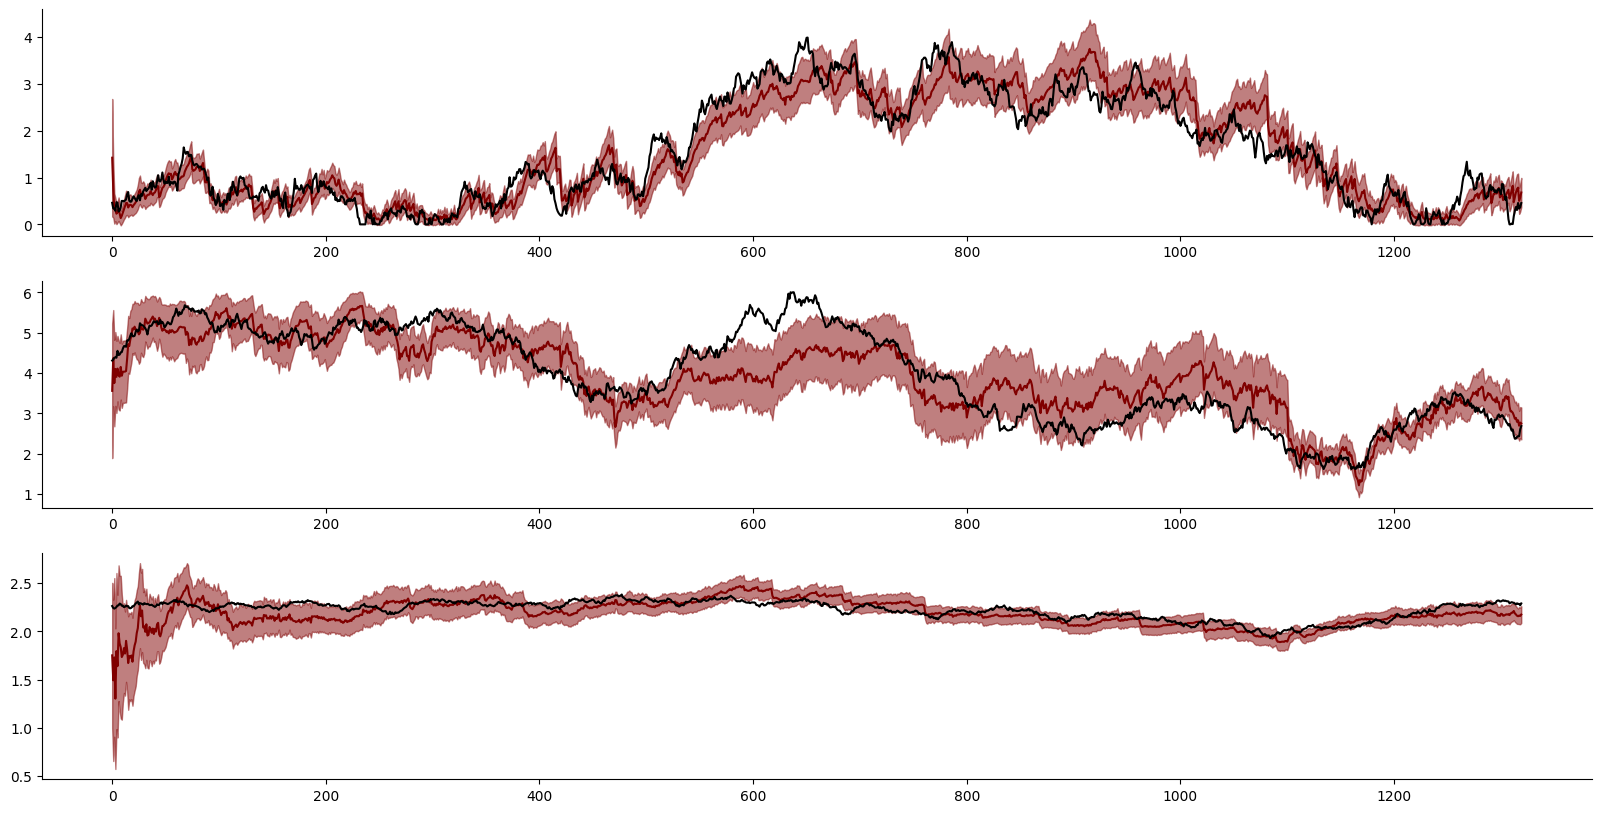

In [29]:
time = np.arange(theta_t_means.shape[0])
f, axarr = plt.subplots(3, 1, figsize=(20, 10))
for i, ax in enumerate(axarr.flat):
    ax.plot(time, theta_t_means[:, i], color='maroon', label='Posterior mean')
    ax.fill_between(
        time,
        theta_t_means[:, i] - theta_t_stds[:, i],
        theta_t_means[:, i] + theta_t_stds[:, i],
        color='maroon',
        alpha=0.5
        )
    ax.plot(time, true_params[:, i], color='black', label='True parameter')
sns.despine()
f.tight_layout


### Fit to empiric data

In [ ]:
# prepare data
data = pd.read_csv('../data/optimal_policy_data.csv')

In [ ]:
which = 0
person_data = {"summary_conditions": data['rt'].loc[data['id'] == which + 1].to_numpy()[None, ..., None]}

In [ ]:
posterior_samples = neural_experiment.amortizer.sample(person_data, NUM_SAMPLES)

In [ ]:
post_means = posterior_samples['local_samples'].mean(axis=1)
post_stds = posterior_samples['local_samples'].std(axis=1)

In [ ]:
f, axarr = plt.subplots(3, 1, figsize=(20, 16))
for i, ax in enumerate(axarr.flat):
    ax.plot(
        np.arange(post_means.shape[0]), post_means[:, i],
        color = "maroon"
    )
    ax.fill_between(
        np.arange(post_means.shape[0]),
        post_means[:, i] - post_stds[:, i],
        post_means[:, i] + post_stds[:, i],
        alpha = 0.5,
        color = "maroon"
    )
    ax.set_xlim([0, post_means.shape[0]])
    ax.set_title(PARAM_LABELS[i] + ' ({})'.format(PARAM_NAMES[i]), fontsize=20)
    if i == 0:
        ax.set_xlabel('Time', fontsize=18)
        ax.set_ylabel("Parameter value", fontsize=18)

    ax.set_title(PARAM_LABELS[i] + ' ({})'.format(PARAM_NAMES[i]), fontsize=20)
    ax.tick_params(axis='both', which='major', labelsize=16)
    
sns.despine()
f.tight_layout()